# In this notebook, we'll visualize reward models using t-SNE and some other tricks

### Prep / installation:
1. Install dependencies from `requirements.txt` in the repository root directory.
2. Clone rl-baselines3-zoo from the repository root directory: `git clone https://github.com/DLR-RM/rl-baselines3-zoo.git`
3. Start up a redis server: `redis-server`

And you're all set!


In [1]:
%matplotlib notebook

import os
import sys
import random
import importlib
from pathlib import Path
from itertools import product
import h5py
from tqdm.auto import tqdm

import pickle
import redis

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import scipy.ndimage

import skimage.transform
import sklearn.manifold

import torch as th
import torch.nn as nn

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

In [2]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


### Define the reward model, adding a method for computing the latent representation (the output of the `feature_extractor`, the input to the final layer $ \in \mathbb{R}^{512}$

In [3]:
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        self.ac_model = ALGOS['a2c']('CnnPolicy', env).policy
        self.reward_net = nn.Linear(512, 1).to(device)
        self.device = device
    
    def forward(self, obs):
        obs_transposed = VecTransposeImage.transpose_image(obs)
        latent, _, _= self.ac_model._get_latent(th.tensor(obs_transposed).to(self.device))
        return self.reward_net(latent)
    
    def latent(self, obs):
        obs_transposed = VecTransposeImage.transpose_image(obs)
        latent, _, _= self.ac_model._get_latent(th.tensor(obs_transposed).to(self.device))
        return latent
    
    def freeze_extractor(self):
        for p in self.ac_model.policy.features_extractor.parameters():
            p.requires_grad = False


### Define saliency map functions

In [4]:
def create_circular_mask(h, w, center, radius=5):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)
    mask = dist_from_center <= radius
    return np.array(mask, dtype=np.float32)

def max_k(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return items

def max_k_and_values(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return list(zip(items, values))

loss_fn = th.nn.MSELoss()
def reward_model_saliency(model: RewardModel, obs, loc, radius=5, device='cuda'):
    obs_copy = np.copy(obs)
    baseline = model(obs_copy)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_copy[0, :, :, k]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_copy[0, :, :, k] = img*(1 - M) + A*M
    modified = model(obs_copy)
    return loss_fn(baseline, modified).item()


def add_saliency_to_image(obs, reward_model, screenshot, radius=5, stride=4):
    pairs = max_k_and_values(10, product(range(0, 84, stride), range(0, 84, stride)), key=lambda e: reward_model_saliency(reward_model, obs, e, radius=radius))
    max_pixel = screenshot.max()
    screenshot = screenshot / max_pixel
    max_value = pairs[0][1] if pairs[0][1] != 0 else 1
    for loc, value in pairs:
        r, g, b, a = matplotlib.cm.hot(value / max_value * 0.7) # prevent 100% intensity from obscuring screenshot completely
        region = create_circular_mask(84, 84, center=loc, radius=radius)
        region = skimage.transform.resize(region, (210, 160))
        spot = np.zeros((210, 160, 3))
        spot[:, :, 0] = r * region
        spot[:, :, 1] = g * region
        spot[:, :, 2] = b * region
        spot = spot * a
        screenshot = spot + (1-spot)*screenshot
        screenshot = screenshot / screenshot.max()
    return screenshot * max_pixel

In [5]:
env_id = "SeaquestNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [6]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


## In this notebook, we're using the %matplotlib notebook flag to enable interaction. Remember to manually hit the power button on the plot to close it down when you're done.

### Load up a seaquest reward model (trained w/ regression)

In [7]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/seaquest_rm_v1.pt", map_location=device))

<All keys matched successfully>

### Play for a while and save states:

In [8]:
COMPUTE_SALIENCY = False

In [9]:
r = redis.Redis()
N = 1500

In [10]:
obs = env.reset()
for k in tqdm(range(N)):
    imgt = env.render(mode='rgb_array')
    obst = obs
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    obst_plus1 = obs
    imgt_plus1 = env.render(mode='rgb_array')
    if COMPUTE_SALIENCY:
        imgt_plus1 = add_saliency_to_image(obst_plus1, rm, imgt_plus1)
    r.set(f'seaquest-cluster0-imgt:{k}', pickle.dumps(imgt), ex=3600)
    r.set(f'seaquest-cluster0-imgt+1:{k}', pickle.dumps(imgt_plus1), ex=3600)
    r.set(f'seaquest-cluster0-imgt+1:{k}', pickle.dumps(imgt_plus1), ex=3600)
    r.set(f'seaquest-cluster0-obst:{k}', pickle.dumps(obst), ex=3600)
    r.set(f'seaquest-cluster0-obst+1:{k}', pickle.dumps(obst_plus1), ex=3600)
    r.set(f'seaquest-cluster0-latent:{k}', pickle.dumps(rm.latent(obs).cpu().detach().numpy()), ex=3600)
    predicted_reward = rm(obs).item()
    r.set(f'seaquest-cluster0-reward:{k}', pickle.dumps(predicted_reward), ex=3600)
    

### Perform t-SNE

In [11]:
X = np.zeros((N, 512))
colors = []

for k in range(N):
    latent = pickle.loads(r.get(f'seaquest-cluster0-latent:{k}'))
    reward = pickle.loads(r.get(f'seaquest-cluster0-reward:{k}'))
    colors.append(reward)
    X[k] = latent

embeddings = sklearn.manifold.TSNE(n_components=2).fit_transform(X)

<IPython.core.display.Javascript object>


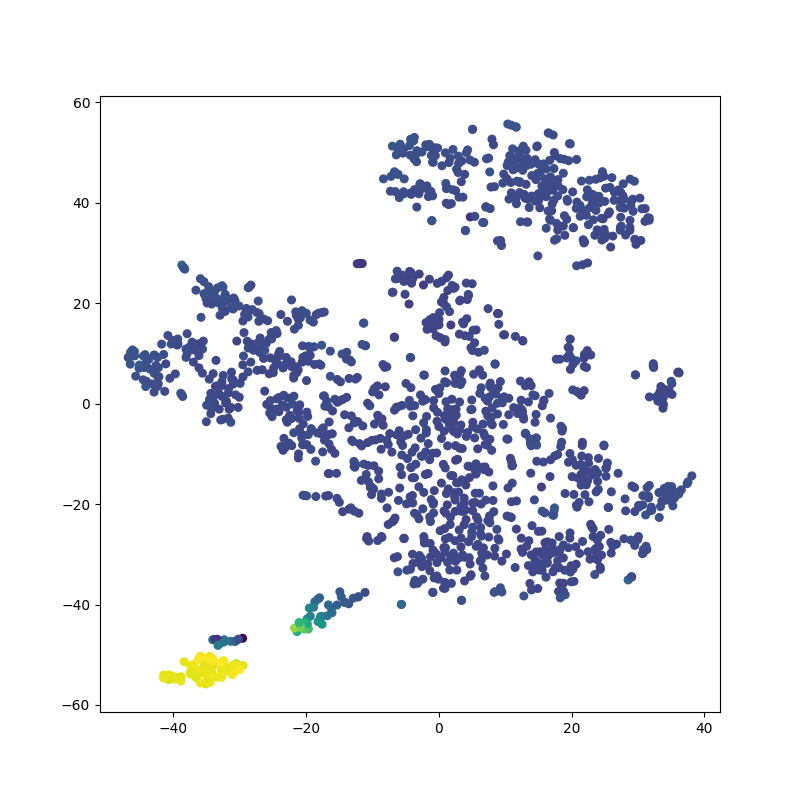

In [12]:
# create figure and plot scatter
fig = plt.figure()
ax = fig.add_subplot(111)
#line, = ax.plot(x,y, ls="", marker="o")
line = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=colors, s=30)

# create the annotations box

image = np.zeros((210, 320, 3), dtype=np.uint16)
image[:, :160, :] = pickle.loads(r.get(f'seaquest-cluster0-imgt:{0}'))
image[:, 160:, :] = pickle.loads(r.get(f'seaquest-cluster0-imgt+1:{0}'))
im = OffsetImage(image, zoom=0.7)
xybox=(100., 100.)
ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
        boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))
# add it to the axes and make it invisible
ax.add_artist(ab)
ab.set_visible(False)

def hover(event):
    # if the mouse is over the scatter points
    if line.contains(event)[0]:
        # find out the index within the array from the event
#        os.system(f"echo {line.contains(event)}")
        ind = line.contains(event)[1]["ind"][0]
        # get the figure size
        w,h = fig.get_size_inches()*fig.dpi
        ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
        hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
        # if event occurs in the top or right quadrant of the figure,
        # change the annotation box position relative to mouse.
        ab.xybox = (xybox[0]*ws, xybox[1]*hs)
        # make annotation box visible
        ab.set_visible(True)
        # place it at the position of the hovered scatter point
        ab.xy =(embeddings[:, 0][ind], embeddings[:, 1][ind])
        # set the image corresponding to that point
        img = np.zeros((210, 320, 3), dtype=np.uint16)
        img[:, :160, :] = pickle.loads(r.get(f'seaquest-cluster0-imgt:{ind}'))
        img[:, 160:, :] = pickle.loads(r.get(f'seaquest-cluster0-imgt+1:{ind}'))
        im.set_data(img)
    else:
        #if the mouse is not over a scatter point
        ab.set_visible(False)
    fig.canvas.draw_idle()

# add callback for mouse moves
fig.canvas.mpl_connect('motion_notify_event', hover)  

fig = plt.gcf()
fig.set_size_inches(8, 8)

# Let's do breakout now

In [18]:
env_id = "BreakoutNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 3
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [19]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [20]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/breakout_rm_v1.pt", map_location=device))

<All keys matched successfully>

In [26]:
COMPUTE_SALIENCY = True

In [27]:
r = redis.Redis()
N = 500

In [28]:
obs = env.reset()
for k in tqdm(range(N)):
    imgt = env.render(mode='rgb_array')
    obst = obs
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    obst_plus1 = obs
    imgt_plus1 = env.render(mode='rgb_array')
    if COMPUTE_SALIENCY:
        imgt_plus1 = add_saliency_to_image(obst_plus1, rm, imgt_plus1)
    r.set(f'breakout-cluster0-imgt:{k}', pickle.dumps(imgt), ex=3600)
    r.set(f'breakout-cluster0-imgt+1:{k}', pickle.dumps(imgt_plus1), ex=3600)
    r.set(f'breakout-cluster0-imgt+1:{k}', pickle.dumps(imgt_plus1), ex=3600)
    r.set(f'breakout-cluster0-obst:{k}', pickle.dumps(obst), ex=3600)
    r.set(f'breakout-cluster0-obst+1:{k}', pickle.dumps(obst_plus1), ex=3600)
    r.set(f'breakout-cluster0-latent:{k}', pickle.dumps(rm.latent(obs).cpu().detach().numpy()), ex=3600)
    predicted_reward = rm(obs).item()
    r.set(f'breakout-cluster0-reward:{k}', pickle.dumps(predicted_reward), ex=3600)
    

In [29]:
X = np.zeros((N, 512))
colors = []

for k in range(N):
    latent = pickle.loads(r.get(f'breakout-cluster0-latent:{k}'))
    reward = pickle.loads(r.get(f'breakout-cluster0-reward:{k}'))
    colors.append(reward)
    X[k] = latent

embeddings = sklearn.manifold.TSNE(n_components=2).fit_transform(X)

<IPython.core.display.Javascript object>


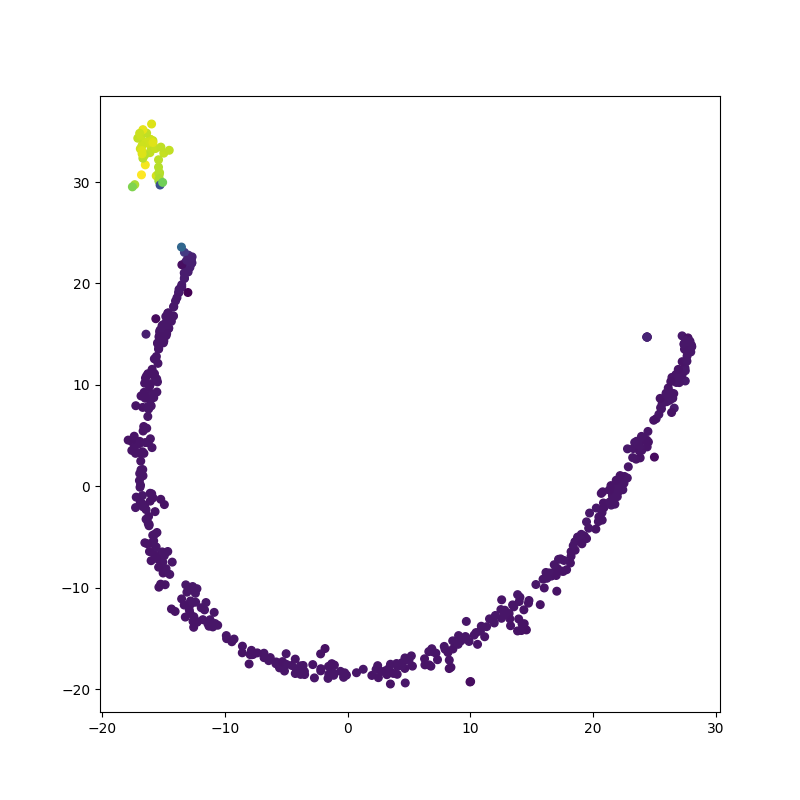

In [30]:
# create figure and plot scatter
fig = plt.figure()
ax = fig.add_subplot(111)
#line, = ax.plot(x,y, ls="", marker="o")
line = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=colors, s=30)

# create the annotations box

image = np.zeros((210, 320, 3), dtype=np.uint16)
image[:, :160, :] = pickle.loads(r.get(f'breakout-cluster0-imgt:{0}'))
image[:, 160:, :] = pickle.loads(r.get(f'breakout-cluster0-imgt+1:{0}'))
im = OffsetImage(image, zoom=0.7)
xybox=(100., 100.)
ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
        boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))
# add it to the axes and make it invisible
ax.add_artist(ab)
ab.set_visible(False)

def hover(event):
    # if the mouse is over the scatter points
    if line.contains(event)[0]:
        # find out the index within the array from the event
#        os.system(f"echo {line.contains(event)}")
        ind = line.contains(event)[1]["ind"][0]
        # get the figure size
        w,h = fig.get_size_inches()*fig.dpi
        ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
        hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
        # if event occurs in the top or right quadrant of the figure,
        # change the annotation box position relative to mouse.
        ab.xybox = (xybox[0]*ws, xybox[1]*hs)
        # make annotation box visible
        ab.set_visible(True)
        # place it at the position of the hovered scatter point
        ab.xy =(embeddings[:, 0][ind], embeddings[:, 1][ind])
        # set the image corresponding to that point
        img = np.zeros((210, 320, 3), dtype=np.uint16)
        img[:, :160, :] = pickle.loads(r.get(f'breakout-cluster0-imgt:{ind}'))
        img[:, 160:, :] = pickle.loads(r.get(f'breakout-cluster0-imgt+1:{ind}'))
        im.set_data(img)
    else:
        #if the mouse is not over a scatter point
        ab.set_visible(False)
    fig.canvas.draw_idle()

# add callback for mouse moves
fig.canvas.mpl_connect('motion_notify_event', hover)  

fig = plt.gcf()
fig.set_size_inches(8, 8)